In [ ]:
# dbutils.library.installPyPI("keras")
# dbutils.library.installPyPI("tensorflow")
# dbutils.library.installPyPI("image")

# dbutils.library.restartPython()

In [30]:
# Standard Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Pipelines for training and evaluating model
from sklearn.pipeline import Pipeline

# Preprocessing/Feature Extraction
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Models 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

# Scoring
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

# Misc
import requests
from PIL import Image
from io import BytesIO
from keras.wrappers.scikit_learn import KerasClassifier
from keras.backend import clear_session

In [2]:
# Converts JSON dictionary of Video Category Ids for 
# a given country into a DataFrame
def json_to_df(path):
    f = lambda x: x.loc['items']['snippet']['title']
    g = lambda x: x.loc['items']['snippet']['assignable']
    h = lambda x: x.loc['items']['id']
    
    df = pd.read_json(path)
    df['Category'] = df.apply(f, axis = 1)
    df['Assignable'] = df.apply(g, axis = 1)
    df['Id'] = df.apply(h, axis = 1)
    df['Id'] = df['Id'].astype(int)
    
    cols = ['Id', 'Category', 'Assignable']
    
    df = df[cols]
    
    return df[df['Assignable']]

In [3]:
countries = ['CA', 'GB', 'US']
data = pd.DataFrame({})

# Concatenating Data
for country in countries:
  
    country_youtube_video_data_path = 'youtube-new/{}videos.csv'.format(country)
    country_category_id_path ='youtube-new/{}_category_id.json'.format(country)
    
    country_category_id_data = json_to_df(country_category_id_path)
    country_youtube_video_data = pd.read_csv(country_youtube_video_data_path)
    
    country_youtube_video_data['category_id'] = country_youtube_video_data['category_id'].astype(int)
    
    video_data_w_category = pd.merge(country_youtube_video_data, 
                                     country_category_id_data,
                                     left_on = 'category_id',
                                     right_on = 'Id')
    
    data = pd.concat([data, video_data_w_category])
    
data['tags'] = (data['tags']
                .str
                .replace('|', ' ')
                .str
                .replace('"', '')
               )
data.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,Id,Category,Assignable
0,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,Eminem Walk On Water Aftermath/Shady/Interscop...,17158579,787425,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...,10,Music,True
1,2Vv-BfVoq4g,17.14.11,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09T11:04:14.000Z,edsheeran ed sheeran acoustic live cover offic...,33523622,1634130,21082,85067,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...,10,Music,True
2,H1KBHFXm2Bg,17.14.11,21 Savage - Bank Account (Official Music Video),21 Savage,10,2017-11-10T19:00:02.000Z,21 savage bank account 21 savage bank account ...,5068229,263596,8585,28976,https://i.ytimg.com/vi/H1KBHFXm2Bg/default.jpg,False,False,False,Watch the official music video of Bank Account...,10,Music,True
3,7MxiQ4v0EnE,17.14.11,Daang ( Full Video ) | Mankirt Aulakh | Sukh S...,Speed Records,10,2017-11-11T16:41:15.000Z,punjabi songs punjabi bhangra punjabi music pu...,5718766,127477,7134,8063,https://i.ytimg.com/vi/7MxiQ4v0EnE/default.jpg,False,False,False,Song - Daang\nSinger - Mankirt Aulakh\nFaceboo...,10,Music,True
4,j67FgNEvyh8,17.14.11,Telefoon || Babbu Maan || Promo || Full Song 1...,Hey Yolo,10,2017-11-12T04:24:34.000Z,Telefoon Babbu Maan Mehfil Mitran Di new punja...,178447,4339,96,876,https://i.ytimg.com/vi/j67FgNEvyh8/default.jpg,False,False,False,"Full Song Out Now 15th November\n\nHey Yolo, S...",10,Music,True


In [4]:
data['Category'].value_counts().to_frame()

,Category
Entertainment,32539
Music,23957
People & Blogs,10241
Comedy,9058
Howto & Style,8081
News & Politics,7871
Film & Animation,6982
Sports,6868
Science & Technology,4074
Gaming,3949


In [5]:
le = LabelEncoder()
X, y = data.drop(['Category'], axis = 1), data['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True)

print('Dataset Length: {}'.format(len(X)),'Training Data Length: {}'.format(len(X_train)),'Number of Response Categories: {}'.format(len(np.unique(y_train))))

Dataset Length: 120375 Training Data Length: 90281 Number of Response Categories: 15


In [6]:
# Dictionary to store different models' performances
model_dict = {'Model':[], 'Training Acc.':[], 'Validation Acc.':[]}

# Return training error and validation error for model
def get_train_val_acc(model):
    scorer = make_scorer(accuracy_score)
    
    model.fit(X_train, y_train)

    preds = model.predict(X_train)
    training_acc = accuracy_score(y_train, preds)
    val_acc = np.mean(cross_val_score(model, X_train, y_train, scoring = scorer, cv = 5))

    return training_acc, val_acc, preds

# Logistic Text-based Model

In [7]:
cols = ['title', 'tags', 'description', 'channel_title']
Cs = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]

# Data Pipeline for Logistic text-based model
model_text_logistic = Pipeline([
    ('Columns', ColumnTransformer([
        ('keep', 'passthrough', cols)
    ])),
    ('Imputation', SimpleImputer(strategy = 'constant', fill_value = '')),
    ('Bag of Words', ColumnTransformer([
        (cols[0], CountVectorizer(stop_words = 'english'), 0),
        (cols[1], CountVectorizer(stop_words = 'english'), 1),
        (cols[2], CountVectorizer(stop_words = 'english'), 2),
        (cols[3], CountVectorizer(stop_words = 'english'), 3)
    ])),
    ('TF-IDF', TfidfTransformer()),
    ('Model Text', LogisticRegressionCV(Cs = Cs, multi_class = 'multinomial', solver = 'sag'))
])

model_text_logistic

Pipeline(memory=None,
         steps=[('Columns',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('keep', 'passthrough',
                                                  ['title', 'tags',
                                                   'description',
                                                   'channel_title'])],
                                   verbose=False)),
                ('Imputation',
                 SimpleImputer(add_indicator=False, copy=True, fill_value='',
                               missing_values=nan, strategy='constant',
                               verbos...
                                  sublinear_tf=False, use_idf=True)),
                ('Model Text',
                 LogisticRegressionCV(Cs=[0.001, 0.002, 0.005, 0.01, 0.02, 0.05,
                                

In [8]:
%%time

# Get training and validation accuracy of Logistic Model
logistic_train_acc, logistic_val_acc, logistic_preds = get_train_val_acc(model_text_logistic)

print('Training Accuracy of Logistic Model: {}'.format(logistic_train_acc))
print('Validation Accuracy of Logistic Model: {}'.format(logistic_val_acc))
print()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, Fut

Training Accuracy of Logistic Model: 0.9983052912572966
Validation Accuracy of Logistic Model: 0.9764623720202744

CPU times: user 1h 14min 14s, sys: 59 s, total: 1h 15min 13s
Wall time: 1h 18min 56s


In [10]:
# Add logistic model's performance to the model dictionary
model_dict['Model'].append('Logistic Model')
model_dict['Training Acc.'].append(logistic_train_acc)
model_dict['Validation Acc.'].append(logistic_val_acc)

/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


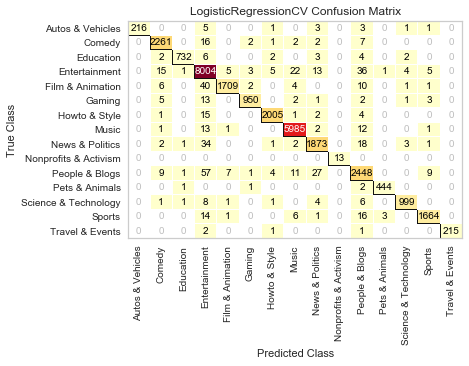

In [18]:
logistic_confusion_matrix = ConfusionMatrix(model_text_logistic, classes = np.unique(data['Category']))
logistic_confusion_matrix.score(X_test, y_test)

logistic_confusion_matrix.show();

# Random Forest Text-based Model

In [11]:
cols = ['title', 'tags', 'description', 'channel_title']

# Data Pipeline for Random Forest text-based model
model_text_rf = Pipeline([
    ('Columns', ColumnTransformer([
        ('keep', 'passthrough', cols)
    ])),
    ('Imputation', SimpleImputer(strategy = 'constant', fill_value = '')),
    ('Bag of Words', ColumnTransformer([
        (cols[0], CountVectorizer(stop_words = 'english'), 0),
        (cols[1], CountVectorizer(stop_words = 'english'), 1),
        (cols[2], CountVectorizer(stop_words = 'english'), 2),
        (cols[3], CountVectorizer(stop_words = 'english'), 3)
    ])),
    ('TF-IDF', TfidfTransformer()),
    ('Model Text', RandomForestClassifier(n_estimators = 200))
])

model_text_rf

Pipeline(memory=None,
         steps=[('Columns',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('keep', 'passthrough',
                                                  ['title', 'tags',
                                                   'description',
                                                   'channel_title'])],
                                   verbose=False)),
                ('Imputation',
                 SimpleImputer(add_indicator=False, copy=True, fill_value='',
                               missing_values=nan, strategy='constant',
                               verbos...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
    

In [12]:
%%time

# Get training and validation accuracy of Random Forest Model
rf_train_acc, rf_val_acc, rf_preds = get_train_val_acc(model_text_rf)

print('Training Accuracy of Logistic Model: {}'.format(rf_train_acc))
print('Validation Accuracy of Logistic Model: {}'.format(rf_val_acc))
print()

Training Accuracy of Logistic Model: 0.9994794031966859
Validation Accuracy of Logistic Model: 0.9721314130254198

CPU times: user 1h 29min 31s, sys: 25.6 s, total: 1h 29min 57s
Wall time: 1h 31min 24s


In [13]:
# Add random forest model's performance to the model dictionary
model_dict['Model'].append('Random Forest Model')
model_dict['Training Acc.'].append(rf_train_acc)
model_dict['Validation Acc.'].append(rf_val_acc)

/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


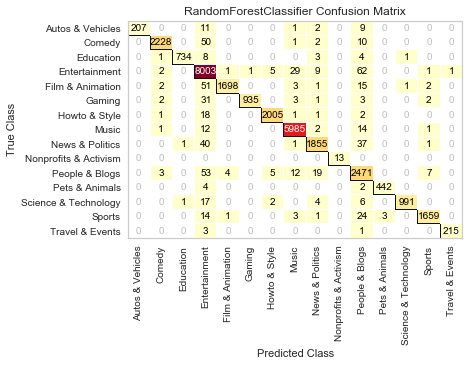

In [17]:
rf_confusion_matrix = ConfusionMatrix(model_text_rf, classes = np.unique(data['Category']))
rf_confusion_matrix.score(X_test, y_test)

rf_confusion_matrix.show();

# Model Performances

In [43]:
model_performance = pd.DataFrame(model_dict, index = model_dict['Model'])
model_performance

,Model,Training Acc.,Validation Acc.
Logistic Model,Logistic Model,0.998305,0.976462
Random Forest Model,Random Forest Model,0.999479,0.972131


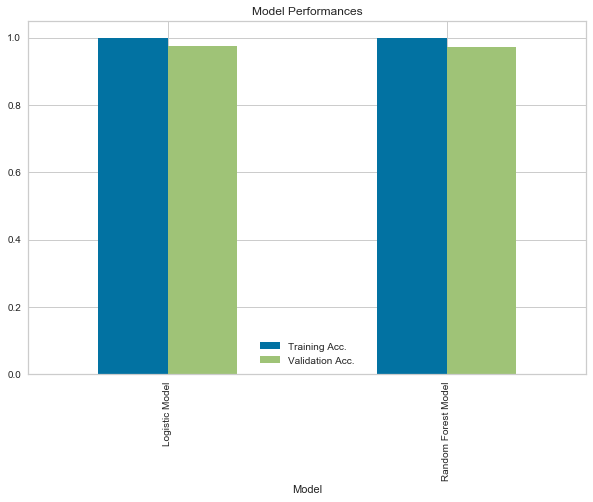

In [61]:
model_performance.plot.bar(x = 'Model',by = model_performance['Model'], figsize = (10,6.5), title = 'Model Performances')